In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

In [8]:
# 데이터 로드
data = pd.read_csv('./data/Regression_data.csv')

# One-hot encode the 'Sex' column
ohe = OneHotEncoder(sparse=False)
sex_encoded = ohe.fit_transform(data[['Sex']])
sex_encoded_df = pd.DataFrame(sex_encoded, columns=ohe.categories_[0])

# Concatenate the one-hot encoded columns to the original data frame
data_encoded = pd.concat([data.drop('Sex', axis=1), sex_encoded_df], axis=1)

# Separate the features from the target
X = data_encoded.drop('Rings', axis=1)
y = data_encoded['Rings']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and validation
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
valid_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

# Cache the datasets and batch them
train_ds = train_ds.cache().shuffle(3500).batch(32)
valid_ds = valid_ds.cache().shuffle(1000).batch(32)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


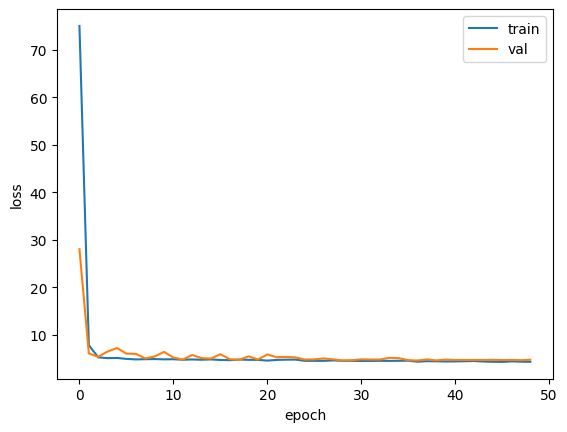

In [11]:

# Define the L1 regularizer
l1 = tf.keras.regularizers.l1(1e-4)

# Define the model
nn = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=[X_train.shape[1],], kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(16, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(8, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1),
])

# Compile the model
nn.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse')

# Define the callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# Train the model
hist = nn.fit(train_ds, validation_data=valid_ds, epochs=200, callbacks=[reduce_lr, e_stop], verbose=0)


# # Plot the loss
# plt.plot(hist.history['loss'], label='train')
# plt.plot(hist.history['val_loss'], label='val')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [ ]:
# Save the model
nn.save('my_model.h5')


In [5]:
from tensorflow.keras.models import load_model

# Load the model
nn = load_model('my_model.h5')

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use the model to make predictions on the test set
y_pred = nn.predict(X_test)

# Flatten the arrays (because the output of the model is a 2D array)
y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

# Calculate the performance metrics
mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)  # or mse**0.5
r2 = r2_score(y_test_flat, y_pred_flat)

# Print the performance metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


27/27 [==============================] - 0s 2ms/step
MAE: 1.4769553656213021
MSE: 4.476184649680055
RMSE: 2.1156995650800834
R2 Score: 0.5865036677494322


In [13]:
# Predict on the test data
y_pred = nn.predict(X_test).flatten()

# Calculate the MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

# Calculate 1 - MAPE
accuracy = 1 - mape

accuracy


27/27 [==============================] - 0s 2ms/step


0.8538742149428515